In [2]:
import numpy as np
import matplotlib.pyplot as plt
import torch
import torchvision
import torchvision.transforms as transforms
import torch.nn.functional as F
import torch.nn as nn
from torch.utils.data import DataLoader
from torch import optim

In [3]:
transform = transforms.Compose([transforms.ToTensor(),
                                transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)) ])
batch_size = 16

trainset = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)
trainloader = DataLoader(trainset, batch_size=batch_size, shuffle=True, num_workers=2)

testset = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=transform)
testloader = DataLoader(testset, batch_size=batch_size, shuffle=False, num_workers=2)

classes = ('plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

Files already downloaded and verified
Files already downloaded and verified


In [4]:
images, labels = next(iter(trainloader))

In [5]:
images.shape

torch.Size([16, 3, 32, 32])

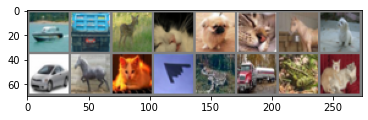

 ship truck  deer   cat   dog   cat horse   dog   car horse   cat plane  frog truck  frog   cat


In [6]:
def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()


# get some random training images
dataiter = iter(trainloader)
images, labels = dataiter.next()

# show images
imshow(torchvision.utils.make_grid(images))
# print labels
print(' '.join('%5s' % classes[labels[j]] for j in range(batch_size)))

In [7]:
class ConvNet(nn.Module):

    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=16, kernel_size=3, padding=1, stride=1)
        self.conv2 = nn.Conv2d(in_channels=16, out_channels=32, kernel_size=3, padding=1, stride=1)
        self.conv3 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, padding=1, stride=1)
        self.conv4 = nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, padding=1, stride=1)
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)
        self.fc1 = nn.Linear(in_features=128*8*8, out_features=512) # 8*8 because we apply pool twice
        self.fc2 = nn.Linear(in_features=512, out_features=256)
        self.fc3 = nn.Linear(in_features=256, out_features=10)
        self.dropout = nn.Dropout(p=0.25) # 25% dropout

    def forward(self, x):
        x = F.relu(self.conv1(x)) # 32*32*16, 16=channels
        x = F.relu(self.conv2(x)) # 32*32*32
        x = self.pool(x)          # 16*16*32 # (2,2) reduces the dimensions in half
        x = self.dropout(x) # helps avoid overfitting
        x = F.relu(self.conv3(x)) # 16*16*64
        x = F.relu(self.conv4(x)) # 16*16*128
        x = self.pool(x)          # 8*8*128
        x = self.dropout(x)

        x = x.view(-1, 8*8*128)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.dropout(x)
        x = self.fc3(x)

        return x


In [8]:
model = ConvNet()
optimizer = optim.Adam(model.parameters(), lr=0.01)
criterion = nn.CrossEntropyLoss()

epochs = 3

In [17]:
best_acc = 0

for e in range(epochs):
    loss_train, loss_test = 0, 0
    
    model.train()
    for i, (images, labels) in enumerate(iter(trainloader)):

        optimizer.zero_grad()
        output = model.forward(images)
        loss = criterion(output, labels)
        loss_train+=loss.item()
        loss.backward()
        optimizer.step()

    model.eval()
    with torch.no_grad():
        correct, total = 0, 0

        for i, (images, labels) in enumerate(iter(testloader)):

            test_output = model(images)
            loss = criterion(test_output, labels)
            loss_test += loss

            pred_y = torch.max(test_output, 1)[1].data.squeeze()
            correct += (pred_y == labels).float().sum()
            total += len(labels)
            accuracy = (pred_y == labels).sum().item() / float(labels.size(0))

    acc = (correct/total).float()*100
    print(f'epoch {e+1} done: accuracy of {acc:.2f}, train_loss:{loss_train/len(trainloader.dataset)} and test_loss: {loss_test/len(testloader.dataset)}')

epoch 1 done: accuracy of 10.00, train_loss:0.14427095923423766 and test_loss: 0.1440432220697403
